In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

In [2]:
from keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Данные:
Будем работать с датасетом [Boston Housing Prices](https://medium.com/@haydar_ai/learning-data-science-day-9-linear-regression-on-boston-housing-dataset-cd62a80775ef).

Text(0.5,0,'Price')

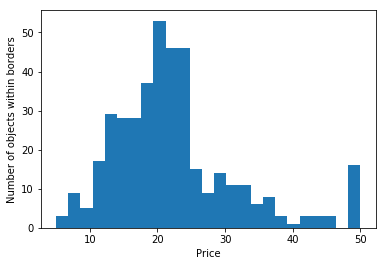

In [3]:
plt.hist(y_train, bins=25)
plt.ylabel('Number of objects within borders')
plt.xlabel('Price')

### Задание.
Будем решать задачу регрессии. Целевая переменная -- цена дома, признаки - различная информация о домохозяйстве. Для решения будем использовать линейную регрессию. Ваша задача - оценить качество решения в зависимости от количества объектов в обучающей выборке. Качество решения будем оценивать с помощью среднеквадратичной и среднеабсолютной ошибки, а так же [коэффициента детерминации $r^2$](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination). Также требуется оценить дисперсию данных функционалов в зависимости от числа объектов в обучающей выборке. 

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Text(0.5,1,'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

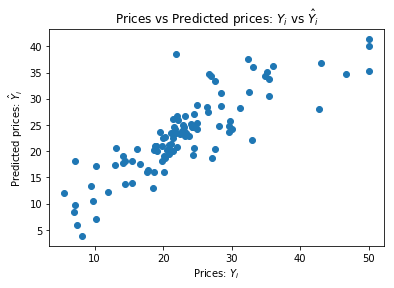

In [5]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_pred = lm.predict(X_test)

plt.scatter(y_test, y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [6]:
print('mae = {}'.format(mean_absolute_error(y_test, y_pred)))
print('mse = {}'.format(mean_squared_error(y_test, y_pred)))
print('prediction variance = {}'.format(np.std((y_test - y_pred)**2)))

mae = 3.464185812406724
mse = 23.195599256422998
prediction variance = 45.78048685033721


In [7]:
def get_list_and_appending_callback():
    lst = list()
    callback = lambda x: lst.append(x)
    return (lst, callback)

In [8]:
def get_random_subset(x, y, size):
    assert len(x) == len(y)
    assert size <= len(x)
    # https://stackoverflow.com/questions/19485641/python-random-sample-of-two-arrays-but-matching-indices
    index = np.random.choice(np.arange(len(x)), size, replace=False)
    return (x[index], y[index])

In [9]:
def check_linear_regression(x, y, callback = None):
    lm = LinearRegression()
    lm.fit(x, y)

    y_pred = lm.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if callback is not None:
        callback((mae, mse, r2))

In [10]:
def check_size(size, x, y, callback = None):
    (x_subset, y_subset) = get_random_subset(x, y, size)
    check_linear_regression(x_subset, y_subset, callback)

In [11]:
def plot_res(res):
    x = np.arange(len(res))
    # https://stackoverflow.com/questions/28176949/convert-list-of-tuples-to-structured-numpy-array
    dt = np.dtype('float,float,float')
    dt.names = ['mae', 'mse', 'r2']
    res = np.array(res, dtype=dt)
    plt.plot(x, res['mae'])
    plt.plot(x, res['mse'])
    plt.plot(x, res['r2'])

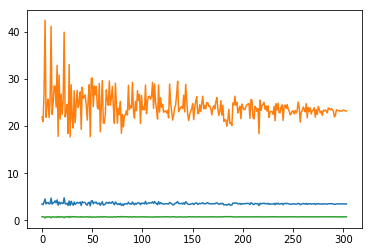

In [12]:
(res, callback) = get_list_and_appending_callback()

for size in range(100, len(y_train)):
    check_size(size, X_train, y_train, callback)
    
plot_res(res)

In [13]:
# # Plot code example from ODS Open Machine Course notebook from lesson 9
# # Source: https://github.com/Yorko/mlcourse_open/blob/master/jupyter_russian/topic09_time_series/topic9_part1_time_series_python.ipynb
#     plt.figure(figsize=(15, 5))
#     plt.plot(prediction_test, label="prediction")
#     plt.plot(lower, "r--", label="upper bond / lower bond")
#     plt.plot(upper, "r--")
#     plt.plot(list(y_test), label="y_test")
#     plt.plot(Anomalies, "ro", markersize=10)
#     plt.legend(loc="best")
#     plt.axis('tight')
#     plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
#     plt.grid(True)
#     plt.legend()

In [14]:
### Your code here